In [1]:
import scanpy as sc
import anndata as ad

import scportrait

import pandas as pd
import spatialdata_plot
import spatialdata

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 7
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'

region_lookup = {"region1":"tonsilitis", "region2":"healthy"}

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_hex

# Define your 5 colors in order
color_list = ['#2F559A', '#5AADC5', '#F5DB12', '#E46425', '#B3262A']

# Create a continuous colormap from these colors
custom_cmap = LinearSegmentedColormap.from_list('custom_gradient', color_list)

def generate_palette(n_colors, custom_cmap):
    palette = [custom_cmap(i / (n_colors - 1)) for i in range(n_colors)]

    # convert to hex colors 
    palette = [to_hex(x) for x in palette]
    return(palette)

palette_15 = generate_palette(15, custom_cmap=custom_cmap)
palette_23 = generate_palette(23, custom_cmap=custom_cmap)

/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [ ]:
region1_spatialdata_object = "/Users/sophia/Documents/GitHub/scportrait_ot/data/region1_scportrait.sdata"
region2_spatialdata_object = "/Users/sophia/Documents/GitHub/scportrait_ot/data/region2_scportrait.sdata"

OT_celltype_predictions_region2 = "/Users/sophia/Documents/Code/scportrait/analysis/CODEX/OT_celltype_predictions/round2/predicted_ct_healthy.h5ad"
OT_celltype_predictions_region1 = "/Users/sophia/Documents/Code/scportrait/analysis/CODEX/OT_celltype_predictions/round2/predicted_ct_tonsilitis.h5ad"

In [ ]:
adata_region1 = ad.read_zarr(f"{region1_spatialdata_object}/tables/CellFeaturizer__nucleus")
adata_region2 = ad.read_zarr(f"{region2_spatialdata_object}/tables/CellFeaturizer__nucleus")

adata_region1.obs["region"] = "region1"
adata_region2.obs["region"] = "region2"

adata_region1 = adata_region1[:, [x for x in adata_region1.var_names if "mean"  in x]]
adata_region2 = adata_region2[:, [x for x in adata_region1.var_names if "mean"  in x]]

adata_region1.var_names = [x.replace("_mean_nucleus", "") for x in adata_region1.var_names]
adata_region2.var_names = [x.replace("_mean_nucleus", "") for x in adata_region2.var_names]

# read celltype annotation with ot

adata_region2_celltypes = ad.read_h5ad(OT_celltype_predictions_region2)
adata_region1_celltypes = ad.read_h5ad(OT_celltype_predictions_region1)

adata_region1.obs = adata_region1.obs.merge(adata_region1_celltypes.obs.get(["scportrait_cell_id", "cell_type"]))
adata_region2.obs = adata_region2.obs.merge(adata_region2_celltypes.obs.get(["scportrait_cell_id", "cell_type"]))

sc.pp.scale(adata_region1)
sc.pp.scale(adata_region2)

In [ ]:
# write annotations back to original objects
import spatialdata
from scportrait.tl.sdata import add_element_sdata

sdata_region1 = spatialdata.read_zarr(region1_spatialdata_object)
sdata_region2 = spatialdata.read_zarr(region2_spatialdata_object)

annotation_region1 = adata_region1.obs.get(["scportrait_cell_id", "cell_type"])
annotation_region1.set_index("scportrait_cell_id", inplace=True)

sdata_region1["CellFeaturizer__nucleus"].obs["OT_celltypes"] = [annotation_region1.loc[x, "cell_type"] for x in sdata_region1["CellFeaturizer__nucleus"].obs["scportrait_cell_id"]]
sdata_region1["CellFeaturizer__nucleus"].obs["OT_celltypes"] = sdata_region1["CellFeaturizer__nucleus"].obs["OT_celltypes"].astype("category")
add_element_sdata(sdata_region1, sdata_region1["CellFeaturizer__nucleus"], "CellFeaturizer__nucleus", overwrite=True)

annotation_region2 = adata_region2.obs.get(["scportrait_cell_id", "cell_type"])
annotation_region2.set_index("scportrait_cell_id", inplace=True)

sdata_region2["CellFeaturizer__nucleus"].obs["OT_celltypes"] = [annotation_region2.loc[x, "cell_type"] for x in sdata_region2["CellFeaturizer__nucleus"].obs["scportrait_cell_id"]]
sdata_region2["CellFeaturizer__nucleus"].obs["OT_celltypes"] = sdata_region2["CellFeaturizer__nucleus"].obs["OT_celltypes"].astype("category")
add_element_sdata(sdata_region2, sdata_region2["CellFeaturizer__nucleus"], "CellFeaturizer__nucleus", overwrite=True)

# plot celltype abundances

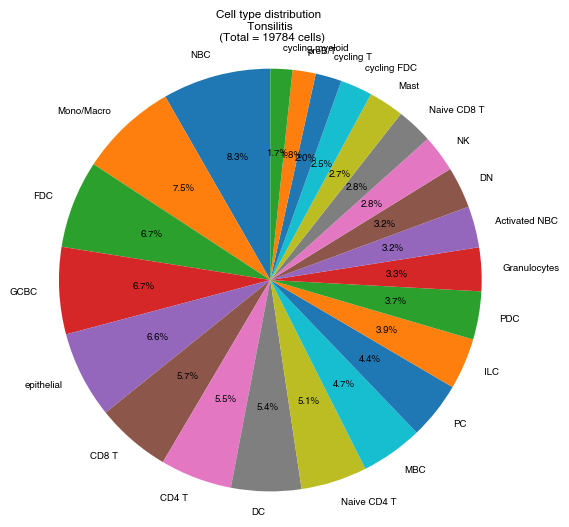

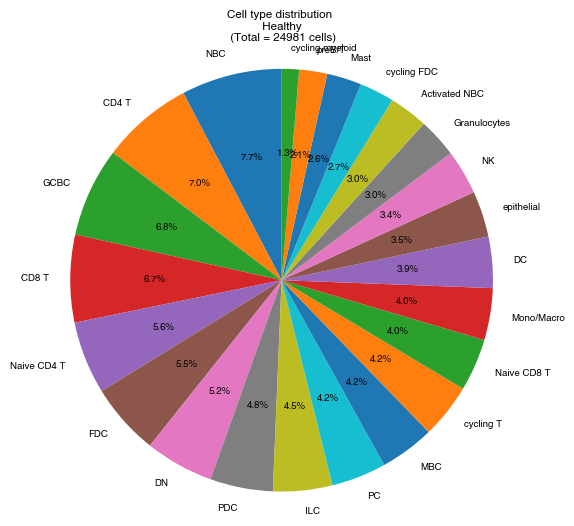

In [4]:
celltype_counts = adata_region1.obs.cell_type.value_counts()

# Data
labels = celltype_counts.index.tolist()
sizes = celltype_counts.values
total = sum(sizes)

# Custom color scheme
# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title(f'Cell type distribution \n Tonsilitis \n (Total = {total} cells)')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
plt.show()

celltype_counts = adata_region2.obs.cell_type.value_counts()

# Data
labels = celltype_counts.index.tolist()
sizes = celltype_counts.values
total = sum(sizes)

# Custom color scheme
# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title(f'Cell type distribution \n Healthy \n (Total = {total} cells)')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
plt.show()

# Visualize spatial distribution

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                


/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `seg_all_nucleus_vectorized` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `_annotation` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/sophia/Documents/GitHub/spatialdata-plot/src/spatialdata_plot/pl/utils.py:798: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)
/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_72771/3636376147.py:14: UserWarning: This figure includes Axes that are not com

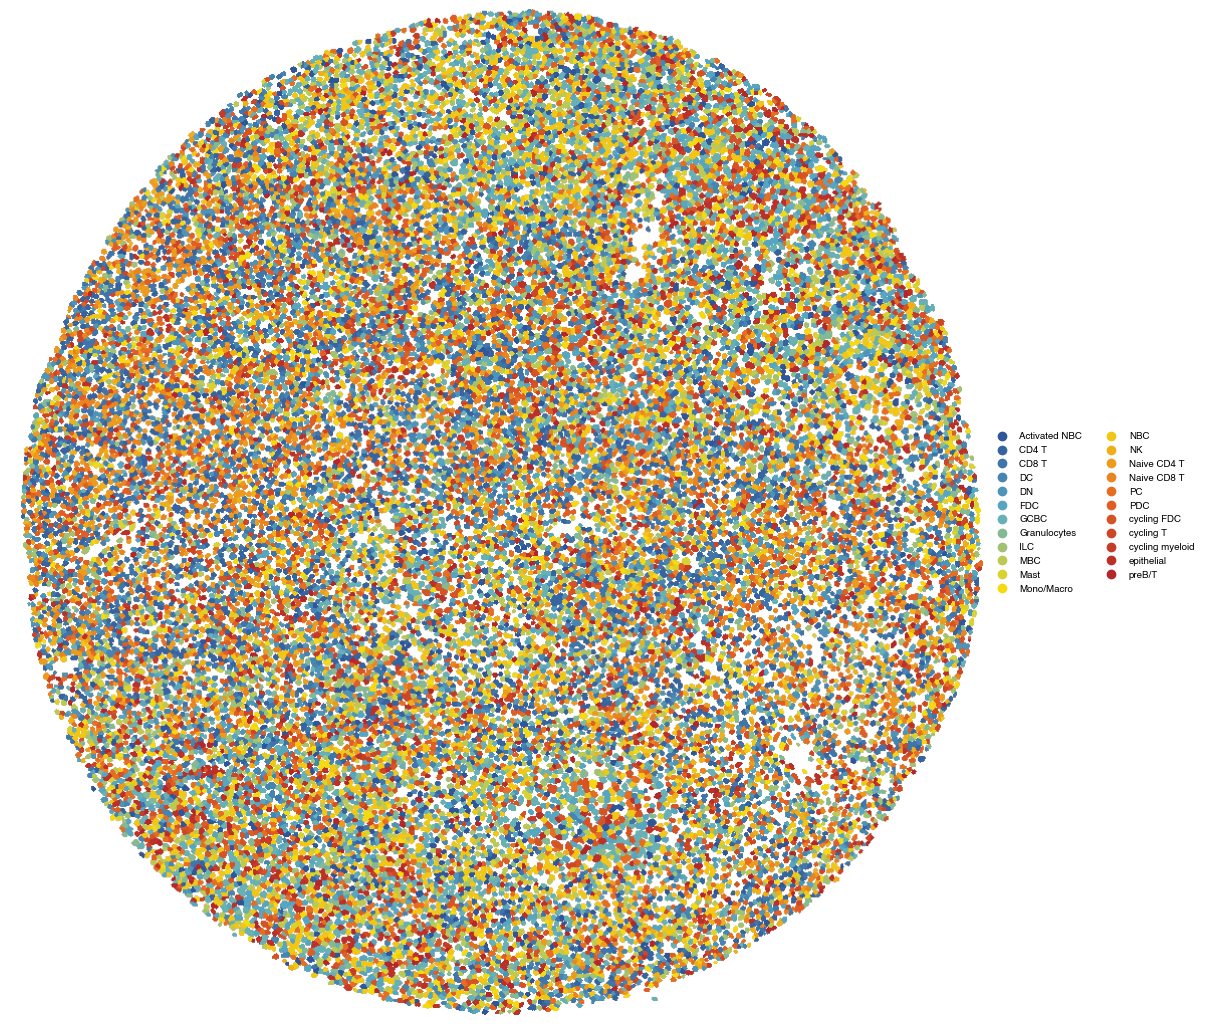

In [5]:
# read preprocessed data
sdata = spatialdata.read_zarr("/Users/sophia/Documents/Code/scportrait/analysis/CODEX/project_codex_region2/scportrait.sdata")

groups = list(sdata["CellFeaturizer__nucleus"].obs["OT_celltypes"].unique())
groups.sort()

fig = scportrait.pl.sdata.plot_labels(sdata, 
                                      palette = palette_23,
                                      groups = groups,
                                      label_layer="seg_all_nucleus",
                                      color = "OT_celltypes", 
                                      return_fig = True, 
                                      vectorized = True)
fig.tight_layout()

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                


/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `seg_all_nucleus_vectorized` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `_annotation` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/sophia/Documents/GitHub/spatialdata-plot/src/spatialdata_plot/pl/utils.py:798: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)
/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_72771/3751266244.py:14: UserWarning: This figure includes Axes that are not com

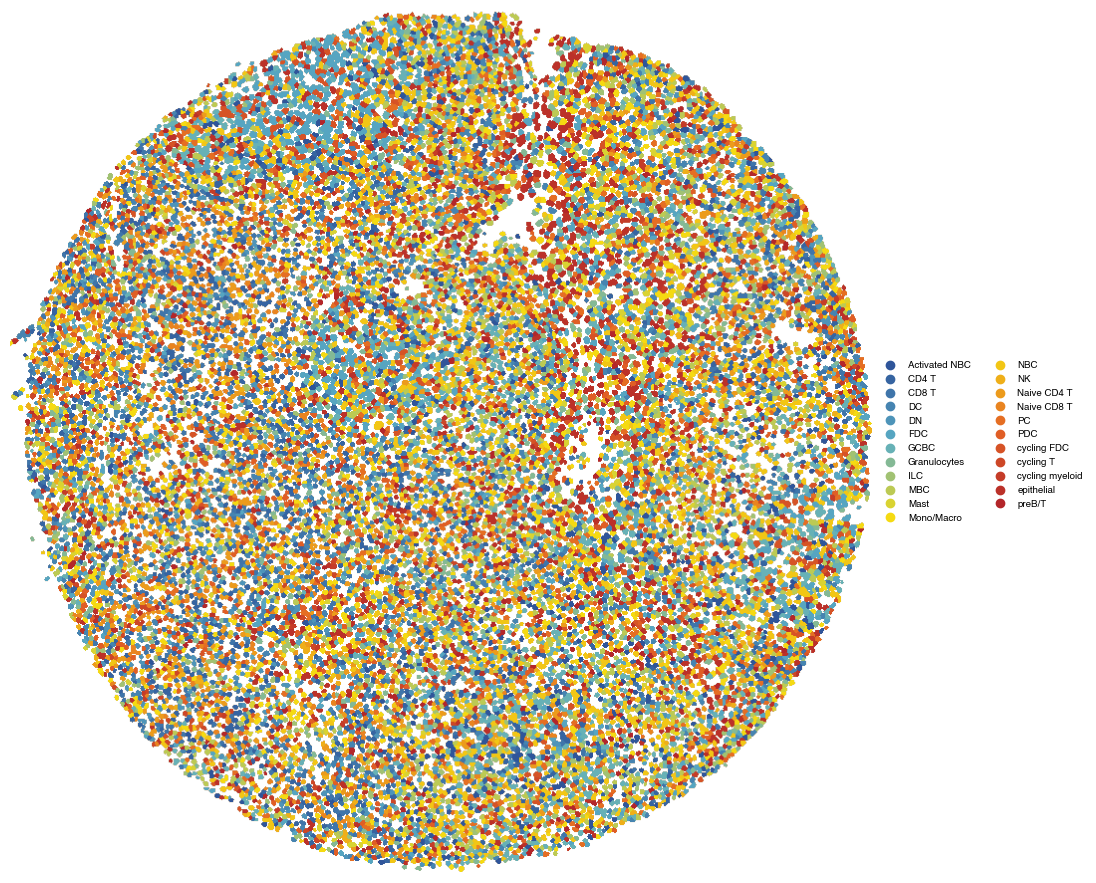

In [6]:
# read preprocessed data
sdata = spatialdata.read_zarr("/Users/sophia/Documents/Code/scportrait/analysis/CODEX/project_codex_region1/scportrait.sdata")

groups = list(sdata["CellFeaturizer__nucleus"].obs["OT_celltypes"].unique())
groups.sort()

fig = scportrait.pl.sdata.plot_labels(sdata, 
                                      palette = palette_23,
                                      groups = groups,
                                      label_layer="seg_all_nucleus",
                                      color = "OT_celltypes", 
                                      return_fig = True, 
                                      vectorized = True)
fig.tight_layout()

## Look at gene expression per cluster

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/py

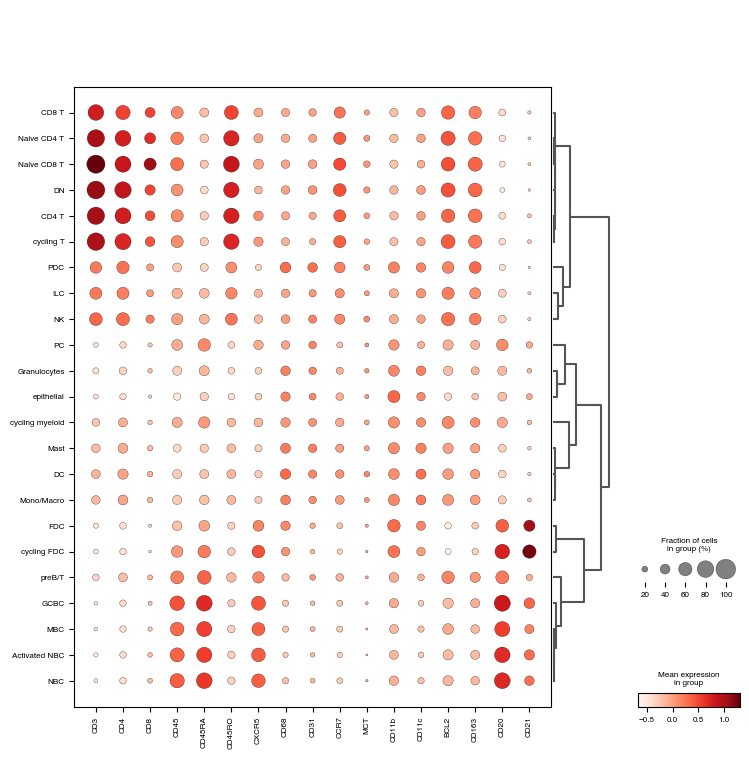

In [3]:
sc.tl.rank_genes_groups(adata_region1, groupby="cell_type", method="wilcoxon")
sc.tl.dendrogram(adata_region1, groupby="cell_type")
fig = sc.pl.dotplot(adata_region1, var_names = ["CD3", "CD4", "CD8", "CD45", "CD45RA", "CD45RO", "CXCR5", "CD68", "CD31", "CCR7", "MCT", "CD11b", "CD11c", "BCL2", "CD163", "CD20", "CD21"], groupby="cell_type", dendrogram=True)


/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value enco

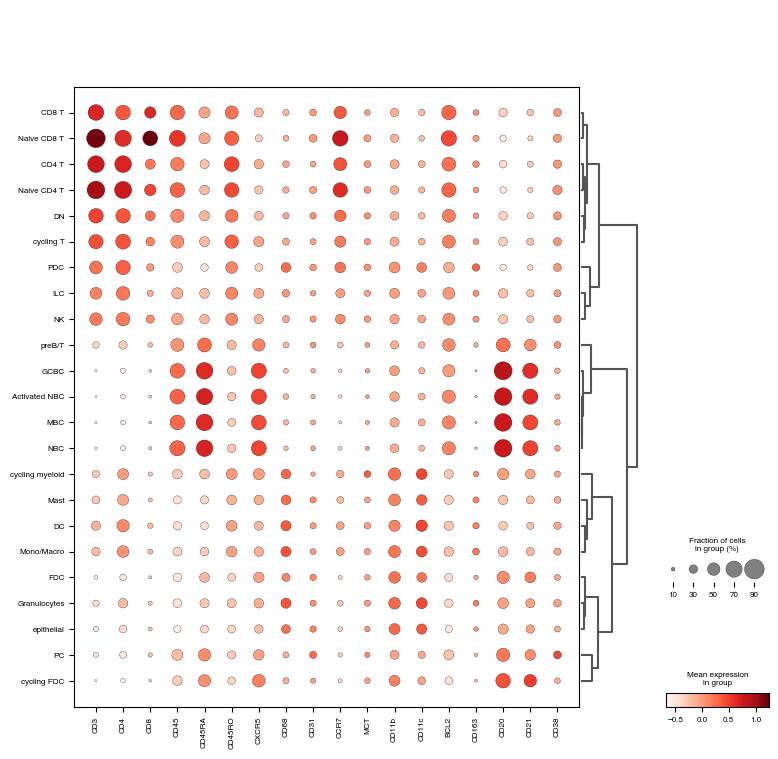

In [12]:
sc.tl.rank_genes_groups(adata_region2, groupby="cell_type", method="wilcoxon")
sc.tl.dendrogram(adata_region2, groupby="cell_type")
fig = sc.pl.dotplot(adata_region2, var_names = ["CD3", "CD4", "CD8", "CD45", "CD45RA", "CD45RO", "CXCR5", "CD68", "CD31", "CCR7", "MCT", "CD11b", "CD11c", "BCL2", "CD163", "CD20", "CD21", "CD38"], groupby="cell_type", dendrogram=True)


# look at expression markers for key cell types

In [49]:
list(adata_region1.obs["cell_type"].unique())

b_cells = ['GCBC',
 'MBC',
 'NBC',
 'Activated NBC']

b_cell_markers = ['CD20', 'PAX5', 'CD21', 'CD38', 'HLA-DR', 'CD138']

t_cells = ['CD8 T',
 'Naive CD4 T',
 'Naive CD8 T',
 'CD4 T',
 'cycling T',
]

t_cell_markers = ['CD3', 'CD4', 'CD8', 'FoxP3', 'CD25',
    'CD45RO', 'CD45RA', 'CCR7', 'CXCR5',
    'GranzymeB', 'Tbet', 'GATA3',
    'PD-1', 'LAG3', 'CD69', 'Ox40',
    'Ki67', 'CD103'
]

## T-cell subsets

/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:667: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_grou

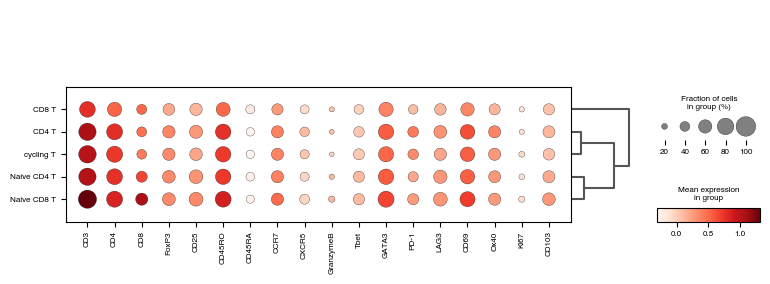

/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value enco

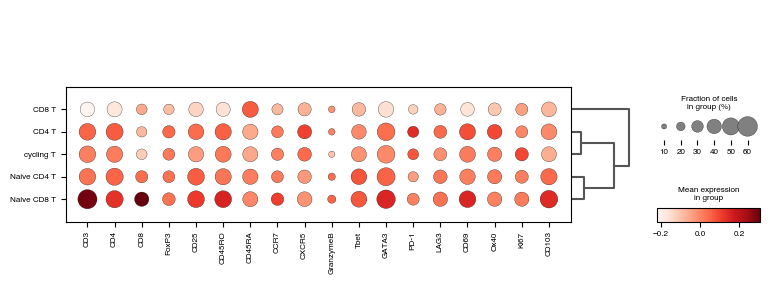

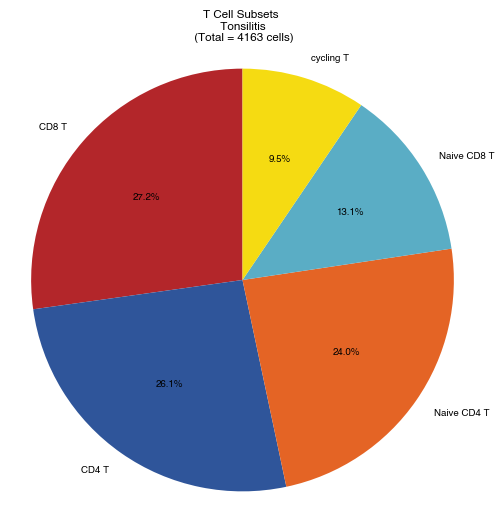

In [53]:
tcell_subset = adata_region1[adata_region1.obs.cell_type.isin(t_cells)]
sc.tl.rank_genes_groups(tcell_subset, groupby="cell_type", method="wilcoxon")
sc.tl.dendrogram(tcell_subset, groupby="cell_type")
fig = sc.pl.dotplot(tcell_subset, var_names = t_cell_markers, groupby="cell_type", dendrogram=True)


sc.pp.scale(tcell_subset)
sc.tl.rank_genes_groups(tcell_subset, groupby="cell_type", method="wilcoxon")
sc.tl.dendrogram(tcell_subset, groupby="cell_type")
fig = sc.pl.dotplot(tcell_subset, var_names = t_cell_markers, groupby="cell_type", dendrogram=True)

celltype_counts = tcell_subset.obs.cell_type.value_counts()

# Data
labels = celltype_counts.index.tolist()
sizes = celltype_counts.values
total = sum(sizes)

# Custom color scheme
colors = ['#b3262a', '#2f559a', '#e46425', '#5aadc5', '#f5db12']

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title(f'T Cell Subsets \n Tonsilitis \n (Total = {total} cells)')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
plt.show()

/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:667: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_grou

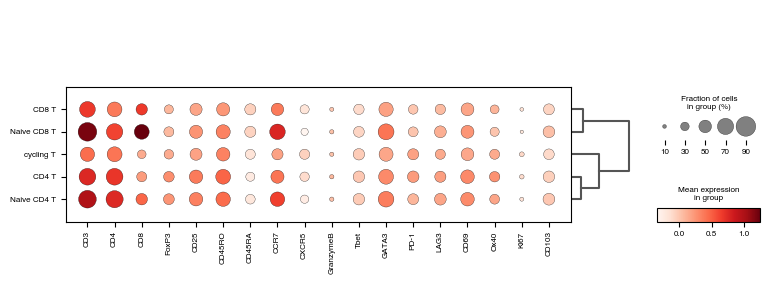

/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value enco

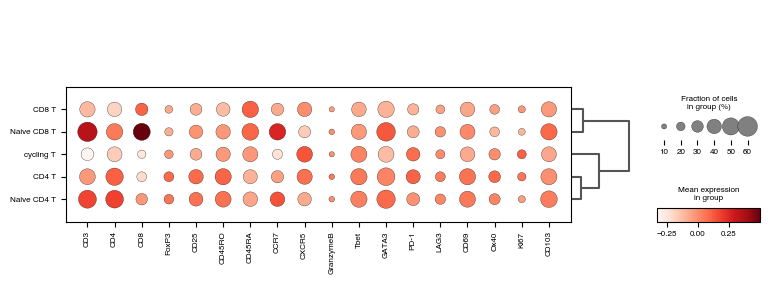

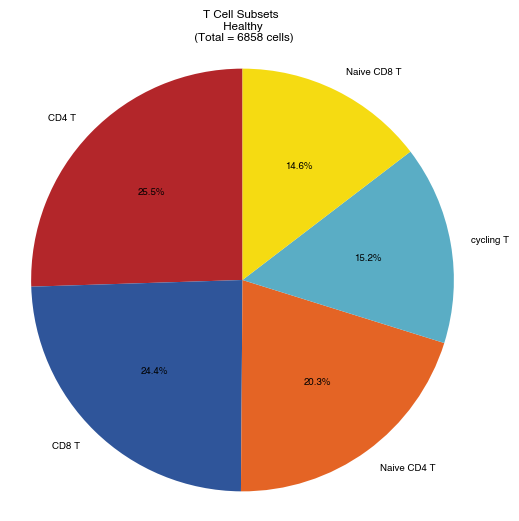

In [52]:
tcell_subset = adata_region2[adata_region2.obs.cell_type.isin(t_cells)]
sc.tl.rank_genes_groups(tcell_subset, groupby="cell_type", method="wilcoxon")
sc.tl.dendrogram(tcell_subset, groupby="cell_type")
fig = sc.pl.dotplot(tcell_subset, var_names = t_cell_markers, groupby="cell_type", dendrogram=True)


sc.pp.scale(tcell_subset)
sc.tl.rank_genes_groups(tcell_subset, groupby="cell_type", method="wilcoxon")
sc.tl.dendrogram(tcell_subset, groupby="cell_type")
fig = sc.pl.dotplot(tcell_subset, var_names = t_cell_markers, groupby="cell_type", dendrogram=True)

celltype_counts = tcell_subset.obs.cell_type.value_counts()

# Data
labels = celltype_counts.index.tolist()
sizes = celltype_counts.values
total = sum(sizes)

# Custom color scheme
colors = ['#b3262a', '#2f559a', '#e46425', '#5aadc5', '#f5db12']

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title(f'T Cell Subsets \n Healthy \n (Total = {total} cells)')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
plt.show()

## B-cell subsets

/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:667: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_grou

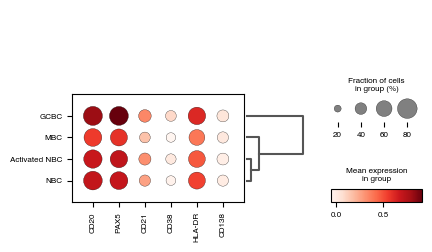

/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


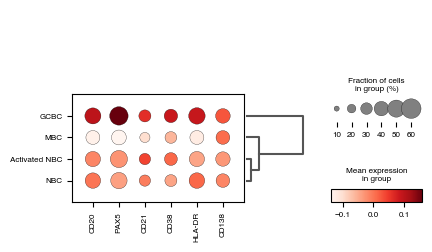

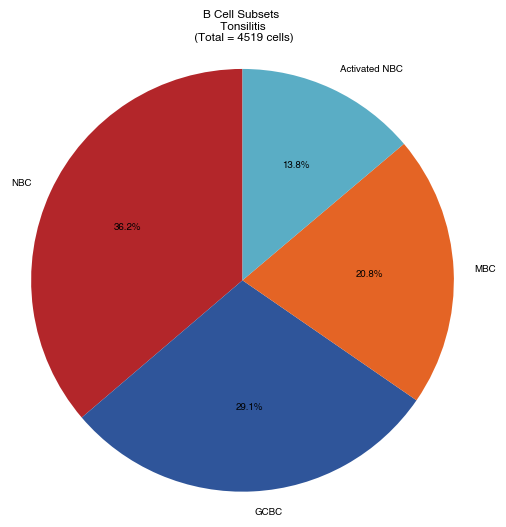

In [44]:
bcell_subset = adata_region1[adata_region1.obs.cell_type.isin(b_cells)]
sc.tl.rank_genes_groups(bcell_subset, groupby="cell_type", method="wilcoxon")
sc.tl.dendrogram(bcell_subset, groupby="cell_type")
fig = sc.pl.dotplot(bcell_subset, var_names = b_cell_markers, groupby="cell_type", dendrogram=True)


sc.pp.scale(bcell_subset)
sc.tl.rank_genes_groups(bcell_subset, groupby="cell_type", method="wilcoxon")
sc.tl.dendrogram(bcell_subset, groupby="cell_type")
fig = sc.pl.dotplot(bcell_subset, var_names = b_cell_markers, groupby="cell_type", dendrogram=True)

celltype_counts = bcell_subset.obs.cell_type.value_counts()

# Data
labels = celltype_counts.index.tolist()
sizes = celltype_counts.values
total = sum(sizes)

# Custom color scheme
colors = ['#b3262a', '#2f559a', '#e46425', '#5aadc5']

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title(f'B Cell Subsets \n Tonsilitis \n (Total = {total} cells)')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
plt.show()

/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:667: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_grou

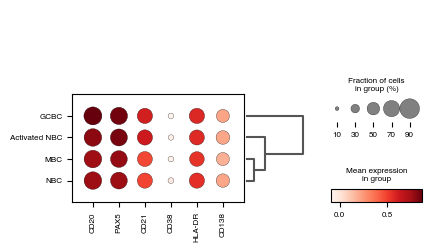

/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


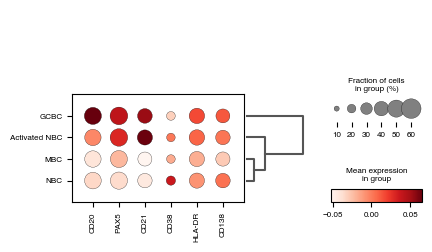

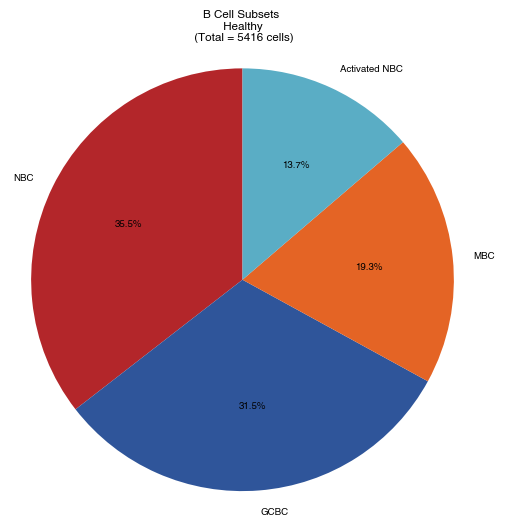

In [45]:
bcell_subset = adata_region2[adata_region2.obs.cell_type.isin(b_cells)]
sc.tl.rank_genes_groups(bcell_subset, groupby="cell_type", method="wilcoxon")
sc.tl.dendrogram(bcell_subset, groupby="cell_type")
fig = sc.pl.dotplot(bcell_subset, var_names = b_cell_markers, groupby="cell_type", dendrogram=True)


sc.pp.scale(bcell_subset)
sc.tl.rank_genes_groups(bcell_subset, groupby="cell_type", method="wilcoxon")
sc.tl.dendrogram(bcell_subset, groupby="cell_type")
fig = sc.pl.dotplot(bcell_subset, var_names = b_cell_markers, groupby="cell_type", dendrogram=True)

celltype_counts = bcell_subset.obs.cell_type.value_counts()

# Data
labels = celltype_counts.index.tolist()
sizes = celltype_counts.values
total = sum(sizes)

# Custom color scheme
colors = ['#b3262a', '#2f559a', '#e46425', '#5aadc5']

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title(f'B Cell Subsets \n Healthy \n (Total = {total} cells)')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
plt.show()

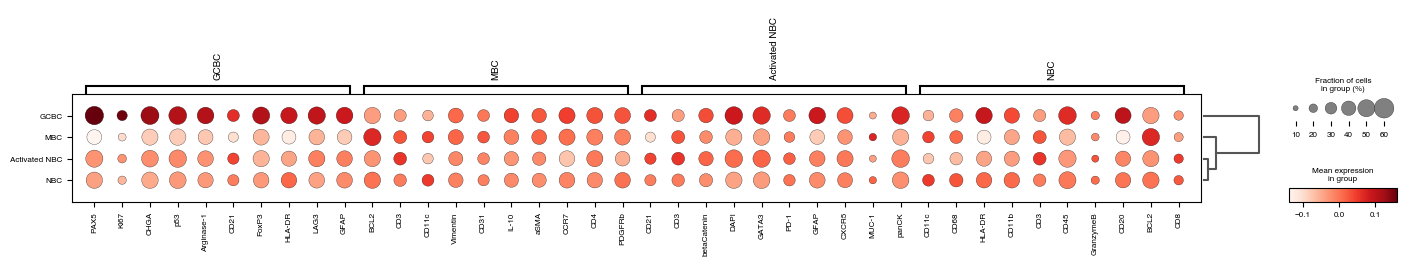

In [27]:
sc.pl.rank_genes_groups_dotplot(bcell_subset, groupby = "cell_type")